[![nbviewer](https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.svg)](https://nbviewer.jupyter.org/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/deJong_Mackay_et_al_2023/convergence.ipynb)
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=examples/PySDM_examples/deJong_Mackay_et_al_2023/convergence.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/deJong_Mackay_et_al_2023/convergence.ipynb)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.environ['NUMBA_NUM_THREADS'] = '10'

In [3]:
!nvidia-smi -q -i 0 | grep "Product Name"

    Product Name                          : Tesla T4


In [4]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
#     pip_install_on_colab('PySDM-examples')

In [5]:
!git clone https://github.com/open-atmos/PySDM.git

fatal: destination path 'PySDM' already exists and is not an empty directory.


In [6]:
%cd /content/PySDM
!pwd
!git pull
!git checkout performance-comparison
!git status

/content/PySDM
/content/PySDM
Already up to date.
Already on 'performance-comparison'
Your branch is up to date with 'origin/performance-comparison'.
On branch performance-comparison
Your branch is up to date with 'origin/performance-comparison'.

nothing to commit, working tree clean


In [7]:
# !pip install -e .
# !pip install -e .[tests]

In [8]:
!cd examples && pip install -e .

Obtaining file:///content/PySDM/examples
  Preparing metadata (setup.py) ... done
  Attempting uninstall: PySDM-examples
    Found existing installation: PySDM-examples 2.24.post3
    Uninstalling PySDM-examples-2.24.post3:
      Successfully uninstalled PySDM-examples-2.24.post3
  Running setup.py develop for PySDM-examples


In [9]:
!pip list | grep PySDM

PySDM                            2.25
PySDM-examples                   2.24.post3            /content/PySDM/examples


In [10]:
!git log -1

commit 5107a54adea9e7c6dcd6ea1da306cc5fe529f934 (HEAD -> performance-comparison, origin/performance-comparison)
Author: Oleksii Bulenok <a.bulenok@student.uj.edu.pl>
Date:   Fri Sep 1 00:29:11 2023 +0200

    Create build and run_convergence_analysis methods in Srivastava Simulation class


In [11]:
import os
from datetime import datetime
import json
from PySDM.physics import si
from PySDM_examples.Srivastava_1982 import coalescence_and_breakup_eq13, Settings
from open_atmos_jupyter_utils import show_plot

import numpy as np
from matplotlib import pyplot
from PySDM_examples.Srivastava_1982.simulation import Simulation
import numba

from PySDM.products import SuperDropletCountPerGridbox, VolumeFirstMoment, ZerothMoment
from PySDM.backends import GPU, CPU
from PySDM.dynamics import Collision
from PySDM.dynamics.collisions.breakup_efficiencies import ConstEb
from PySDM.dynamics.collisions.breakup_fragmentations import ConstantSize
from PySDM.dynamics.collisions.coalescence_efficiencies import ConstEc
from PySDM.dynamics.collisions.collision_kernels import ConstantK

In [12]:
%cd /content/drive/MyDrive/perf_comp
!pwd

/content/drive/MyDrive/perf_comp
/content/drive/MyDrive/perf_comp


In [13]:
MY_SETUP_INFO_FILENAME="Colab_GPU_env_info"
import os
assert not os.path.isfile(MY_SETUP_INFO_FILENAME)

!echo NUMBA_DEFAULT_NUM_THREADS: $numba.config.NUMBA_DEFAULT_NUM_THREADS >> $MY_SETUP_INFO_FILENAME
!echo NUMBA_NUM_THREADS: $numba.config.NUMBA_NUM_THREADS >> $MY_SETUP_INFO_FILENAME
!lscpu >> $MY_SETUP_INFO_FILENAME
!cat /proc/cpuinfo >> $MY_SETUP_INFO_FILENAME
!nvidia-smi >> $MY_SETUP_INFO_FILENAME

AssertionError: ignored

In [ ]:
# !cat $SETUP_INFO_FILENAME

In [14]:
dt = 1 * si.s
dv = 1 * si.m**3
drop_mass_0=1 * si.g
total_number=1e12

NO_BOUNCE = ConstEb(1)

TIMESTAMP = None

In [15]:
class ProductsNames:
  super_particle_count = "super_particle_count"
  total_volume="total_volume"
  total_number="total_number"


def setup_simulation(settings, n_sd, seed):


  products=(
      SuperDropletCountPerGridbox(
          name=ProductsNames.super_particle_count
      ),
      VolumeFirstMoment(name=ProductsNames.total_volume),
      ZerothMoment(name=ProductsNames.total_number)
  )

  collision_rate = settings.srivastava_c + settings.srivastava_beta
  simulation = Simulation(
      n_steps=None,
      settings=settings,
      collision_dynamic=Collision(
          collision_kernel=ConstantK(a=collision_rate),
          coalescence_efficiency=ConstEc(settings.srivastava_c / collision_rate),
          breakup_efficiency=NO_BOUNCE,
          fragmentation_function=ConstantSize(c=settings.frag_mass / settings.rho),
          warn_overflows=False,
          adaptive=False
      ),
  )
  particulator = simulation.build(n_sd, seed, products=products)

  return particulator

In [16]:
def setup_coalescence_only_sim(n_sd, backend_class, seed):

  title = "fig_coalescence-only"
  c = 0.5e-6 / si.s
  beta = 1e-15 / si.s
  frag_mass = -1 * si.g

  settings = Settings(
      srivastava_c=c,
      srivastava_beta=beta,
      frag_mass=frag_mass,
      drop_mass_0=drop_mass_0,
      dt=dt,
      dv=dv,
      n_sds=(),
      total_number=total_number,
      backend_class=backend_class,
  )

  return setup_simulation(settings, n_sd, seed)

In [17]:
def setup_breakup_only_sim(n_sd, backend_class, seed):
  title = "fig_breakup-only"
  c =  1e-15 / si.s
  beta = 1e-9 / si.s
  frag_mass = 0.25 * si.g

  settings = Settings(
      srivastava_c=c,
      srivastava_beta=beta,
      frag_mass=frag_mass,
      drop_mass_0=drop_mass_0,
      dt=dt,
      dv=dv,
      n_sds=(),
      total_number=total_number,
      backend_class=backend_class,
  )
  return setup_simulation(settings, n_sd, seed)

In [18]:
def setup_coalescence_breakup_sim(n_sd, backend_class, seed):
  title = "fig_coalescence-breakup"
  c =  0.5e-6 / si.s
  beta = 1e-9 / si.s
  frag_mass = 0.25 * si.g

  settings = Settings(
      srivastava_c=c,
      srivastava_beta=beta,
      frag_mass=frag_mass,
      drop_mass_0=drop_mass_0,
      dt=dt,
      dv=dv,
      n_sds=(),
      total_number=total_number,
      backend_class=backend_class,
  )
  return setup_simulation(settings, n_sd, seed)

In [19]:
TIMESTAMP = str(datetime.now())

Benchmark function

In [20]:
import time

def print_all_products(particulator):
  print(ProductsNames.total_number, particulator.products[ProductsNames.total_number].get())
  print(ProductsNames.total_volume, particulator.products[ProductsNames.total_volume].get())
  print(ProductsNames.super_particle_count, particulator.products[ProductsNames.super_particle_count].get())


def go_benchmark(setup_sim, n_sds, n_steps, seeds, numba_n_threads=[None]):
  dt = datetime.now()
  TIMESTAMP = str(dt)

  results = {}

  cpu_backends_configs = [(CPU, i) for i in numba_n_threads]
  backend_configs = [*cpu_backends_configs, (GPU, None)]

  for backend_class, n_threads in backend_configs:
    backend_name = backend_class.__name__
    if n_threads:
      backend_name += "_" + str(n_threads)
      numba.set_num_threads(n_threads)

    results[backend_name] = {}

    print('\n', 'before')

    for n_sd in n_sds:
      print()
      print(backend_name, n_sd)
      print()
      results[backend_name][n_sd] = {}

      for seed in seeds:
        particulator = setup_sim(n_sd, backend_class, seed)
        particulator.run(steps=1)

        t0 = time.time()
        particulator.run(steps=n_steps)
        t1 = time.time()

        elapsed_time_per_timestep = (t1 - t0) / n_steps

        print('\n', 'after')
        print_all_products(particulator)

        results[backend_name][n_sd][seed] = elapsed_time_per_timestep

  return results


In [21]:
def process_results(res_d):
  processed_d = {}
  for backend in res_d.keys():
    processed_d[backend] = {}

    for n_sd in res_d[backend].keys():
      processed_d[backend][n_sd] = {}

      vals = res_d[backend][n_sd].values()
      vals = np.array(list(vals))

      processed_d[backend][n_sd]['mean'] = np.mean(vals)
      processed_d[backend][n_sd]['std'] = np.std(vals)
      processed_d[backend][n_sd]['max'] = np.amax(vals)
      processed_d[backend][n_sd]['min'] = np.amin(vals)

  return processed_d

In [22]:
def write_to_file(filename, d):
  assert not os.path.isfile(filename)

  with open(filename, "w") as fp:
    json.dump(d, fp)


def read_dict_from_file(filename):
  with open(filename, "r") as fp:
       return json.load(fp)


def plot_processed_results(processed_d, show=True, plot_label='', plot_title=None):
  x = []
  y = []

  backends = list(processed_d.keys())
  assert 'Numba' in backends[0]
  markers = {backend: 'o' if 'Numba' in backend else 'x' for backend in backends}

  for backend in backends:
    for n_sd in processed_d[backend].keys():
      if n_sd not in x:
        x.append(n_sd)

  x.sort()

  for backend in backends:
    y = []
    for n_sd in x:
      v = processed_d[backend][n_sd]['min']
      y.append(v)

    pyplot.plot(x, y, label=backend+plot_label, marker=markers[backend])

  pyplot.legend(bbox_to_anchor =(1.35, 0.75))
  pyplot.xscale('log', base=2)
  pyplot.yscale('log', base=2)
  pyplot.grid()
  pyplot.xticks(x)
  pyplot.xlabel("number of super-droplets")
  pyplot.ylabel("wall time per timestep [s]")

  if plot_title:
    pyplot.title(plot_title)

  if show:
    show_plot()


def plot_processed_on_same_plot(coal_d, break_d, coal_break_d):
  plot_processed_results(coal_d, plot_label='-c', show=False)
  plot_processed_results(break_d, plot_label='-b', show=False)
  plot_processed_results(coal_break_d, plot_label='-cb', show=False)

  show_plot()

#Benchmark Simulation RUN

In [23]:
#n_sds = [i * 64 for i in [2, 8, 32, 128, 512, 2048, 8192]]
#n_sds = [16384, 65536,  262144, 1048576, 4194304]
n_sds = [2 ** i for i in [3, 5, 8, 10, 12, 14, 16, 18, 20, 22, 24]]

numba_n_threads = [1, 2, 4, 6, 8, 10]

n_realisations = 3
n_steps = 100

seeds = list(range(n_realisations))

### Benchmark Coalescence-only

In [60]:
res_coalescence_only = go_benchmark(setup_coalescence_only_sim, n_sds, n_steps, seeds, numba_n_threads=numba_n_threads)


 before

Numba_1 8



NameError: ignored

In [25]:
coalescence_only_processed = process_results(res_coalescence_only)
print(coalescence_only_processed)

{'Numba_1': {8: {'mean': 0.0007532572746276854, 'std': 0.0002770488692569123, 'max': 0.001142280101776123, 'min': 0.0005183720588684082}, 32: {'mean': 0.0005335458119710286, 'std': 1.3817796398086065e-05, 'max': 0.0005508756637573242, 'min': 0.0005170607566833496}, 256: {'mean': 0.0007932829856872559, 'std': 0.00013967414177090885, 'max': 0.0009637188911437989, 'min': 0.0006215953826904297}, 4096: {'mean': 0.004472394784291585, 'std': 0.0012358382115459682, 'max': 0.006201205253601075, 'min': 0.0033858299255371095}, 16384: {'mean': 0.007598240375518799, 'std': 0.00046036838214880637, 'max': 0.008245203495025635, 'min': 0.007211611270904541}, 65536: {'mean': 0.010285805066426594, 'std': 0.004435141923320477, 'max': 0.01655501365661621, 'min': 0.006982400417327881}, 262144: {'mean': 0.025323431491851806, 'std': 0.007214065636595926, 'max': 0.03552416801452637, 'min': 0.020071916580200196}, 1048576: {'mean': 0.07391491969426472, 'std': 0.007820157532079531, 'max': 0.08382471799850463, 'mi

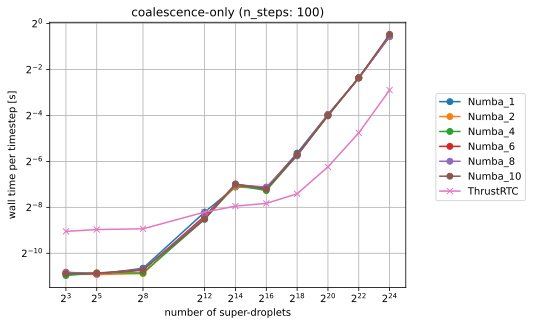

Button(description='tmprayqfc55.pdf', style=ButtonStyle())

In [38]:
plot_processed_results(coalescence_only_processed, plot_title=f'coalescence-only (n_steps: {n_steps})')

In [44]:
filename=f"{MY_SETUP_INFO_FILENAME}-results-{TIMESTAMP}-coalescence.txt"
write_to_file(filename=filename, d=coalescence_only_processed)

### Benchmark Breakup-only

In [ ]:
res_breakup_only = go_benchmark(setup_breakup_only_sim, n_sds, n_steps, seeds, numba_n_threads=numba_n_threads)


 before

Numba_1 8


 after
total_number [4.e+12]
total_volume [1000000.]
super_particle_count [8.]

 after
total_number [4.e+12]
total_volume [1000000.]
super_particle_count [8.]

 after
total_number [4.e+12]
total_volume [1000000.]
super_particle_count [8.]

Numba_1 32


 after
total_number [4.e+12]
total_volume [1000000.]
super_particle_count [32.]

 after
total_number [4.e+12]
total_volume [1000000.]
super_particle_count [32.]

 after
total_number [4.e+12]
total_volume [1000000.]
super_particle_count [32.]

Numba_1 256


 after
total_number [4.e+12]
total_volume [1000000.]
super_particle_count [256.]

 after
total_number [4.e+12]
total_volume [1000000.]
super_particle_count [256.]

 after
total_number [4.e+12]
total_volume [1000000.]
super_particle_count [256.]

Numba_1 1024


 after
total_number [4.e+12]
total_volume [1000000.]
super_particle_count [1024.]

 after
total_number [4.e+12]
total_volume [1000000.]
super_particle_count [1024.]

 after
total_number [4.e+12]
total_volume

In [ ]:
breakup_only_processed = process_results(res_breakup_only)

In [ ]:
# plot_processed_results(breakup_only_processed, plot_title='breakup-only')

In [ ]:
filename=f"{MY_SETUP_INFO_FILENAME}-results-{TIMESTAMP}-breakup.txt"
write_to_file(filename=filename, d=breakup_only_processed)

### Coalescence and Breakup

In [ ]:
res_coal_breakup = go_benchmark(setup_coalescence_breakup_sim, n_sds, n_steps, seeds, numba_n_threads=numba_n_threads)

In [ ]:
coal_breakup_processed = process_results(res_coal_breakup)

In [ ]:
# plot_processed_results(coal_breakup_processed, plot_title='coalescence+breakup')

In [ ]:
filename=f"{MY_SETUP_INFO_FILENAME}-results-{TIMESTAMP}-coal+breakup.txt"
write_to_file(filename=filename, d=coal_breakup_processed)

#Write to file

In [ ]:
d = {'coalescence': coalescence_only_processed, 'breakup': breakup_only_processed, 'coalescence+breakup': coal_breakup_processed}

In [ ]:
filename=f"{MY_SETUP_INFO_FILENAME}-results-{TIMESTAMP}"
write_to_file(filename=filename, d=d)



### All in one

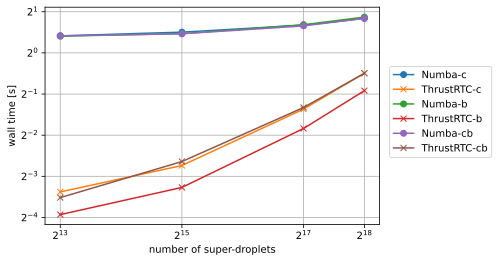

HTML(value="<a href='./tmpg_vaukij.pdf' target='_blank'>./tmpg_vaukij.pdf</a><br>")

In [ ]:
# plot_processed_on_same_plot(coalescence_only_processed, breakup_only_processed, coal_breakup_processed)

In [ ]:
print(coalescence_only_processed)

{'Numba': {8192: {'mean': 1.3789687007501925, 'std': 0.036640895842616324, 'max': 1.4335168749967124, 'min': 1.333165693002229}, 32768: {'mean': 1.4446310670027742, 'std': 0.030326255337438848, 'max': 1.4952143600021373, 'min': 1.4178081450008904}, 131072: {'mean': 1.6885794640020322, 'std': 0.06582652368607261, 'max': 1.7578829140038579, 'min': 1.5959651020020829}, 262144: {'mean': 1.8763832952499797, 'std': 0.07688739003884582, 'max': 1.985494270993513, 'min': 1.7871670439999434}}, 'ThrustRTC': {8192: {'mean': 0.10062026125160628, 'std': 0.0033919362714881504, 'max': 0.10507592099747853, 'min': 0.09620289399754256}, 32768: {'mean': 0.15459566149911552, 'std': 0.00452692793939192, 'max': 0.16167662999941967, 'min': 0.15008084099827101}, 131072: {'mean': 0.39673149775080674, 'std': 0.012512631023731029, 'max': 0.41820974300208036, 'min': 0.3881452499990701}, 262144: {'mean': 0.7242121910021524, 'std': 0.011665275605993015, 'max': 0.7400721740050358, 'min': 0.7108114550064784}}}
